In [16]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches

import pandas as pd
import geopandas as gpd
import numpy as np

# II

# Descargo tablas de referencia
lands = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/ldown_c.csv')
countries_ref = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/countries_ref.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [17]:
# III Merging the tables

# It's neccessary to merge the databases of lands(lands types) and world (geographic reference), 
# using countries_ref as a reference table, to obtain the main df with all the necessary data.

##########################################################
# The study is done just whith the data of the 2016 year #
##########################################################
lands = lands[lands.year==2016]

# Merge the three tables:
l_c = countries_ref.merge(lands,left_on='name_l', right_on='country')
w_l_c = world.merge(l_c,
                    left_on = world['name'].str.strip().str.lower(), 
                    right_on=l_c['name_w'].str.strip().str.lower()).drop(columns=['name', 'key_0'], axis=1)


# Replace the string of types in order of simplify their names
lrep = {'Land area (thousand hectares)':'LA',
        'Arable land (thousand hectares)': 'AL', 'Arable land (% of total land area)':'AL_%',
        'Forest cover (thousand hectares)':'FC', 'Forest cover (% of total land area)':'FC_%',
        'Permanent crops (thousand hectares)':'PC','Permanent crops (% of total land area)':'PC_%',
        'Important sites for terrestrial biodiversity protected (% of total sites protected)':'IB%'}

# Main df with al the data            
w_l_c['type'] = w_l_c['type'].map(lrep)

# IV
# Creating the dataframe to calcule the main indicators
AL = w_l_c[['name_l','name_w','pop_est','value', 'geometry', 'continent']][w_l_c['type']=='AL'].rename(columns={'value':'AL'}).reset_index(drop=True)
PC = w_l_c[['value']][w_l_c['type']=='PC'].rename(columns={'value':'PC'}).reset_index(drop=True)
LA = w_l_c[['value']][w_l_c['type']=='LA'].rename(columns={'value':'LA'}).reset_index(drop=True)

w_land = pd.concat([AL, PC, LA], axis=1, join='inner')

for name in ('name_w','name_l'):
    w_land[name] = w_land[name].str.strip()
    #w_land['name_l'] = w_land['name_l'].str.strip()


def noNaN(df,values):
    for v in values:
        df[values] = df[values].replace(np.nan, 0)
        return df[values]

noNaN(w_land,['AL','PC','LA'])

# V
# Creating the indicators:
# CL, CL%(AL + PC), 'pop_est%', 'density' and 'density_CL', HpF, ref, ind
w_land['CL']= w_land['AL']+w_land['PC']
w_land['CL%']= 100*w_land['CL']/w_land['LA']
w_land['pop_est%'] = 100* w_land['pop_est']/w_land['pop_est'].sum()
w_land['density'] = (w_land['pop_est']/4)/(0.1 + w_land['LA']*1000)
w_land['density_CL'] = (w_land['pop_est']/4)/(0.1+w_land['CL']*1000)

ref_val = 1 #---->> Ha Reference Value!!!!

w_land['HpF'] = (4000) * w_land['CL']/w_land['pop_est']
w_land['ref'] = w_land['HpF'] - ref_val
w_land = w_land.sort_values(by=['continent', 'ref']).reset_index(drop=True)
w_land['name_l']= w_land['name_l'].str.capitalize()
w_land['ind'] = w_land['HpF'].apply(lambda x: 'over' if x >=ref_val else 'under')

## Exceptions:
w_land = w_land[~w_land['name_w'].str.contains('falkland is.|n. cyprus')] 


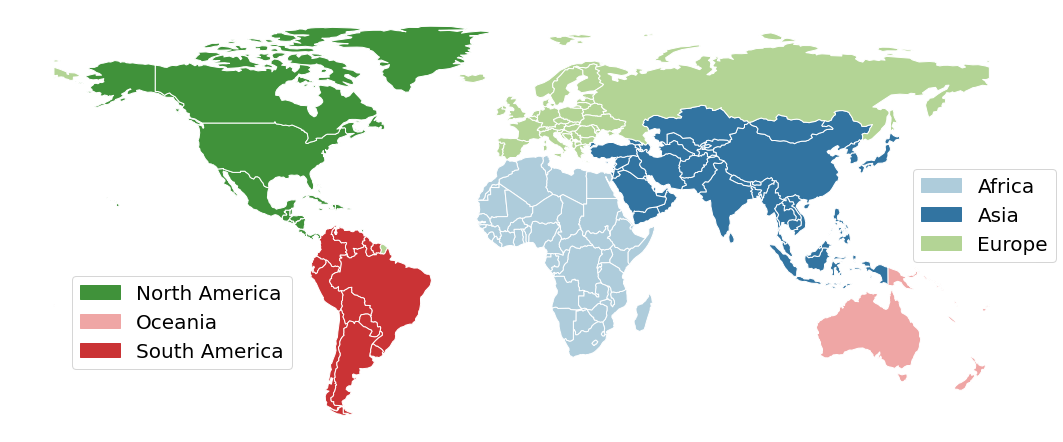

In [19]:
# VI

plt.rcParams.update({'ytick.labelleft':'off',
                     'ytick.labelright':'off',
                     'xtick.labelbottom':'off',
                     'axes.spines.left': False,
                     'axes.spines.bottom' : False,
                     'axes.spines.top': False,
                     'axes.spines.right':False,
                     'ytick.left':False,
                     'xtick.bottom':False,
                     })

# Note: this color_list variable is created in the ha_ref.ipynb file; in order to use the same colors
# in both plots: ha_ref and world_map
c_list = [(0.6808823529411763, 0.7985294117647057, 0.8602941176470589, 1.0), 
              (0.19460784313725488, 0.4563725490196078, 0.632843137254902, 1.0),
              (0.7004901960784313, 0.8328431372549019, 0.5828431372549019, 1.0),
              (0.25, 0.5705882352941177, 0.22941176470588232, 1.0), 
              (0.9362745098039217, 0.6509803921568625, 0.6480392156862743, 1.0),
              (0.7916666666666666, 0.20049019607843133, 0.20637254901960778, 1.0)]

w_cont = w_land.continent.unique()



fig, cx1 = plt.subplots(1, 1, figsize=(15, 15))

for c in range(len(c_list)):
    cx1 = w_land[w_land["continent"] == w_cont[c]].plot(ax=cx1, color=c_list[c], 
                                        legend=True,
                                        edgecolor='white')

    
cx1.patch.set_facecolor('white')

## Adding the legend
patchList = []
for k in range(len(c_list)):
        data_color = mpatches.Patch(color=c_list[k], label=w_cont[k])
        patchList.append(data_color)


l1 = plt.legend(handles=patchList[3:6], ncol=1, loc='lower center', bbox_to_anchor=(0.17,0.13), fontsize=20)
l2 = plt.legend(handles=patchList[:3], ncol=1, loc='lower center', bbox_to_anchor=(0.95,0.38), fontsize=20)

plt.gca().add_artist(l1)

plt.tight_layout()

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/world_map.png', bbox_inches='tight')
plt.show()
